## Sensitivity to Localisation

Post-processing results of `run_FilterComparisonLocalisation.py`

In [2]:
import numpy as np
from matplotlib import pyplot as plt

Background information plots

In [3]:
import Sampler
import Simulator
import Statistics

In [4]:
timestamp = "2022_03_02-12_44_46"
grid, simulator = Simulator.from_file(timestamp)


In [5]:
result_timestep = "2023_06_14-10_34_04" # Single
result_timestep = "2023_06_14-14_43_57"

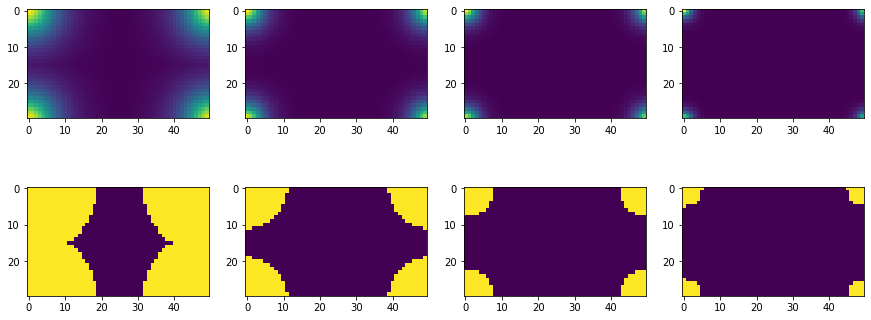

In [6]:
# LOCALISATION IEWPF
f = open("experiment_files/experiment_"+timestamp+"/localisation_results_"+result_timestep, "r")
iewpfQphis = [float(phi) for phi in f.readline().split(" ")[2].split(",")]
f.close()
# iewpfQphis = [3.0, 4.0, 7.0, 11.0]

iewpfQs = [ Sampler.Sampler(grid, {"mean_upshift" : 0.0, "matern_phi" : phi, "stddev" : simulator.noise_stddev} ).cov for phi in iewpfQphis]

fig, axs = plt.subplots(2,len(iewpfQphis), figsize=(15,6))
for m in range(len(iewpfQphis)):
    axs[0,m].imshow(1/simulator.noise_stddev**2*iewpfQs[m][0].reshape(grid.ny, grid.nx), vmin=0.0)
    axs[1,m].imshow(1/simulator.noise_stddev**2*iewpfQs[m][0].reshape(grid.ny, grid.nx)>0.025, vmin=0.0)


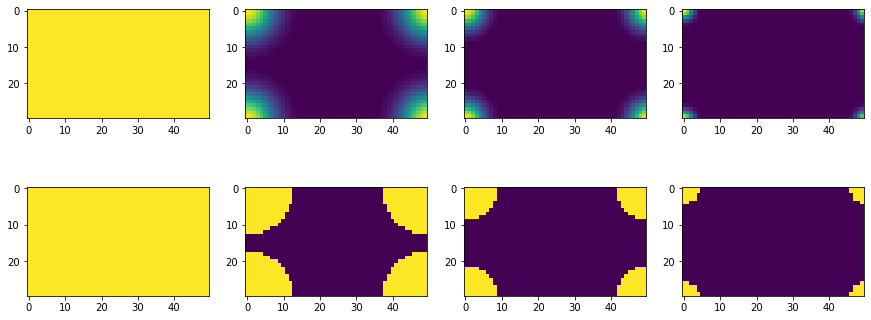

In [7]:
# LOCALISATION LETKF
import SLETKalmanFilter
scale_rs = [9,6,3]

W0s = [ SLETKalmanFilter.SLETKalman.getCombinedWeights(np.zeros((1,2)), scale_r, grid.dx, grid.dy, grid.nx, grid.ny, None, 1.0) for scale_r in scale_rs]
W0s = [np.ones((grid.ny, grid.nx))] + W0s

fig, axs = plt.subplots(2,len(W0s), figsize=(15,6))
for m in range(len(W0s)):
    axs[0,m].imshow(W0s[m], vmin=0.0)
    axs[1,m].imshow(W0s[m]>0.025, vmin=0.0)

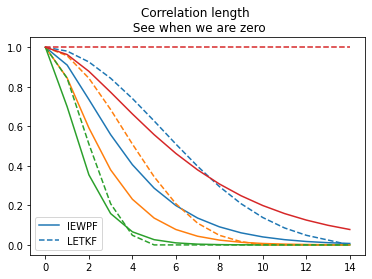

In [8]:
plt.title("Correlation length \n See when we are zero")

plt.plot(1/simulator.noise_stddev**2*iewpfQs[1][0][0:15], c="C0", label="IEWPF")
plt.plot(1/simulator.noise_stddev**2*iewpfQs[2][0][0:15], c="C1")
plt.plot(1/simulator.noise_stddev**2*iewpfQs[3][0][0:15], c="C2")

plt.plot(W0s[1][0][0:15], c="C0", ls="--", label="LETKF")
plt.plot(W0s[2][0][0:15], c="C1", ls="--")
plt.plot(W0s[3][0][0:15], c="C2", ls="--")

plt.plot(1/simulator.noise_stddev**2*iewpfQs[0][0][0:15], c="C3")
plt.plot(W0s[0][0][0:15], c="C3", ls="--")

plt.legend()

Loading from file

In [11]:
single = ""
# single = "Single"

In [12]:
kf_means = np.load("experiment_files/experiment_" + timestamp + "/loc"+single+"_KFmeans_"+result_timestep+".npy")
kf_covs = np.load("experiment_files/experiment_" + timestamp + "/loc"+single+"_KFcovs_"+result_timestep+".npy")

states_iewpf = np.load("experiment_files/experiment_" + timestamp + "/loc"+single+"_IEWPFQ_"+result_timestep+".npy")
states_letkf = np.load("experiment_files/experiment_" + timestamp + "/loc"+single+"_LETKFr_"+result_timestep+".npy")

In [13]:
labels = ["no loc", "wide", "middle", "slim"]

RMSEs

In [14]:
np.average(np.sqrt(np.sum((np.average(states_iewpf, axis=-1) - kf_means)**2, axis=-1)),axis=-1)

array([0.99619223, 0.65571021, 1.61931153, 3.85124153])

In [15]:
np.average(np.sqrt(np.sum((np.average(states_letkf, axis=-1) - kf_means)**2, axis=-1)),axis=-1)

array([2.13241287, 0.90496784, 1.12982931, 2.67412184])

Mean Error Fields

$$\frac{1}{|\text{trials}|}\sum_{\text{trials}}|\bf{err}^{\text{KF}}_{\text{mean}}|$$

In [16]:
mean_vmax = 0.125
if single != "":
    mean_vmax = 0.25

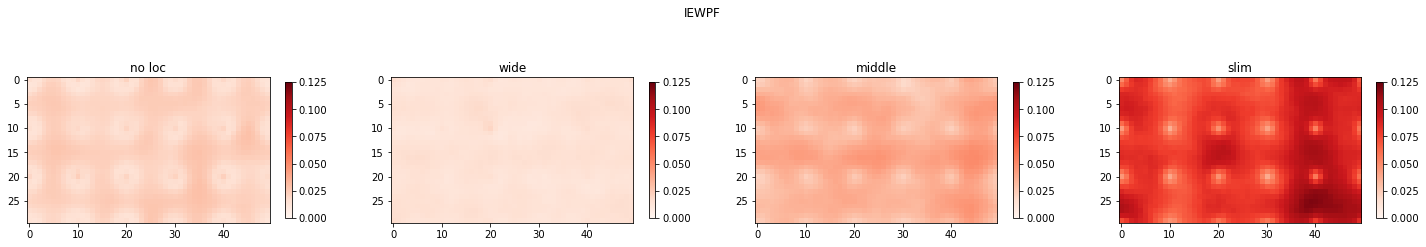

In [17]:
fig, axs = plt.subplots(1,len(states_iewpf), figsize=(25,5))
fig.suptitle("IEWPF", y=0.90)
for m in range(len(states_iewpf)):
    im = axs[m].imshow(np.mean(np.sqrt((np.mean(states_iewpf[m],axis=-1)-kf_means[m])**2), axis=0).reshape(30,50), vmin=0.0, vmax=mean_vmax, cmap="Reds")
    plt.colorbar(im, ax=axs[m], shrink=0.5)
    axs[m].set_title(labels[m])

In [18]:
cov_vminmax = 0.0125
if single != "":
    cov_vminmax = 0.05

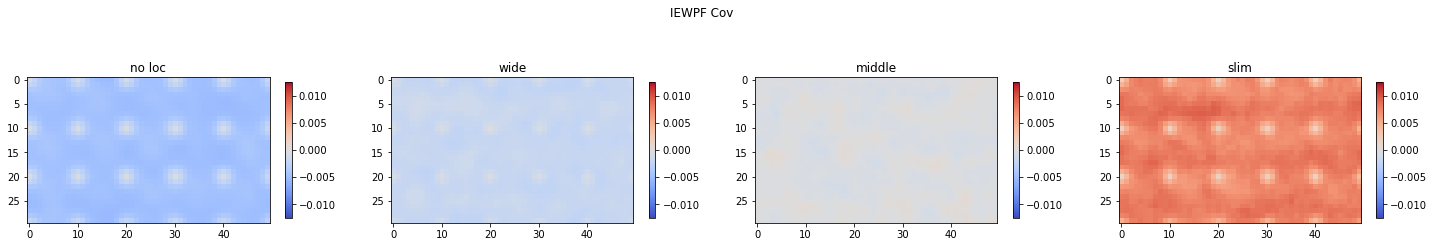

In [19]:
fig, axs = plt.subplots(1,len(states_iewpf), figsize=(25,5))
fig.suptitle("IEWPF Cov", y=0.90)
for m in range(len(states_iewpf)):
    im = axs[m].imshow(np.mean(np.var(states_iewpf[m],axis=-1) - np.array([np.diag(kf_covs[m][i]) for i in range(100)]), axis=0).reshape(30,50), vmin=-cov_vminmax, vmax=cov_vminmax, cmap="coolwarm")
    plt.colorbar(im, ax=axs[m], shrink=0.5)
    axs[m].set_title(labels[m])

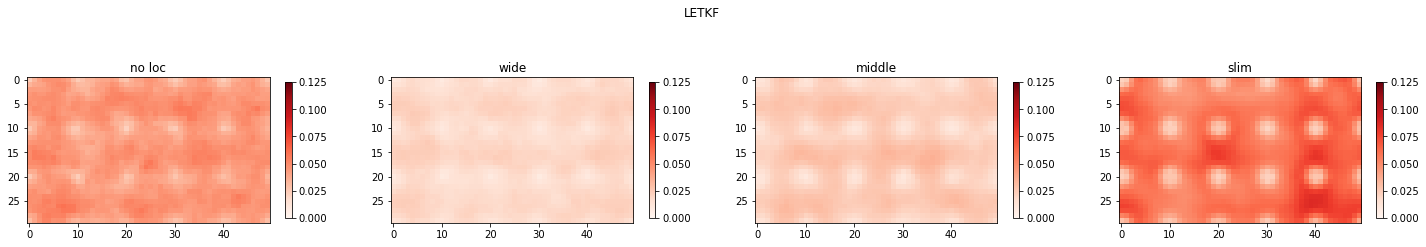

In [20]:
fig, axs = plt.subplots(1,len(iewpfQphis), figsize=(25,5))
fig.suptitle("LETKF", y=0.90)
for m in range(len(iewpfQphis)):
    im = axs[m].imshow(np.mean(np.sqrt((np.mean(states_letkf[m],axis=-1)-kf_means[m])**2), axis=0).reshape(30,50), vmin=0.0, vmax=mean_vmax, cmap="Reds")
    plt.colorbar(im, ax=axs[m], shrink=0.5)
    axs[m].set_title(labels[m])

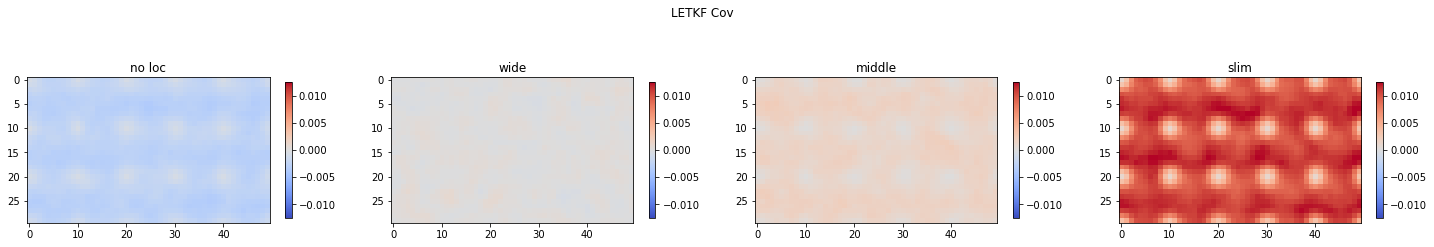

In [21]:
fig, axs = plt.subplots(1,len(iewpfQphis), figsize=(25,5))
fig.suptitle("LETKF Cov", y=0.90)
for m in range(len(iewpfQphis)):
    im = axs[m].imshow(np.mean(np.array([np.var(states_letkf[m][i],axis=-1)-np.diag(kf_covs[m][i]) for i in range(100)]), axis=0).reshape(30,50), vmin=-cov_vminmax, vmax=cov_vminmax, cmap="coolwarm")
    plt.colorbar(im, ax=axs[m], shrink=0.5)
    axs[m].set_title(labels[m])

In [23]:
STOP

NameError: name 'STOP' is not defined

Saving

In [17]:
xgrid = np.arange(grid.nx)*grid.dx
ygrid = np.arange(grid.ny)*grid.dy
xgrids, ygrids = np.meshgrid(xgrid,ygrid)

In [18]:
for m in range(4):
    table = np.column_stack((xgrids.flatten(), ygrids.flatten(), np.mean(np.sqrt((np.mean(states_iewpf[m],axis=-1)-kf_means[m])**2), axis=0).flatten()))
    np.savetxt("rmse_field_iewpf_"+labels[m]+".csv", table, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')

In [19]:
for m in range(4):
    table = np.column_stack((xgrids.flatten(), ygrids.flatten(), np.mean(np.sqrt((np.mean(states_letkf[m],axis=-1)-kf_means[m])**2), axis=0).flatten()))
    np.savetxt("rmse_field_letkf_"+labels[m]+".csv", table, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')

In [20]:
for m in range(4):
    table = np.column_stack((xgrids.flatten(), ygrids.flatten(), np.mean(np.var(states_iewpf[m],axis=-1) - np.array([np.diag(kf_covs[m][i]) for i in range(100)]), axis=0).flatten()))
    np.savetxt("coverr_field_iewpf_"+labels[m]+".csv", table, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')

In [30]:
for m in range(4):
    table = np.column_stack((xgrids.flatten(), ygrids.flatten(), np.mean(np.var(states_letkf[m],axis=-1) - np.array([np.diag(kf_covs[m][i]) for i in range(100)]), axis=0).flatten()))
    np.savetxt("coverr_field_letkf_"+labels[m]+".csv", table, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')